# SOSE Data - cleaned version
Bottom Temperature and Salinity to compare with ECCOv4r3 and WOA products

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.53:45531")
client

Client Scheduler: tcp://10.32.16.53:45531 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import regionmask
import geopandas

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
ocean_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ocean_cat = intake.Catalog(ocean_url)
ds = ocean_cat["SOSE"].to_dask()

In [4]:
coords_before_drop = ds.coords.to_dataset().reset_coords().roll(XC=700, XG=700) #ds split into coords
dsr_before_drop = ds.reset_coords(drop=True).roll(XC=700, XG=700) #ds dropping coords so it just holds data variables

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  """Entry point for launching an IPython kernel.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  


In [5]:
dsr = dsr_before_drop.drop(['XC', 'YC', 'XG', 'YG'])
coords = coords_before_drop.drop(['XC', 'YC', 'XG', 'YG'])

In [6]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880

In [7]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

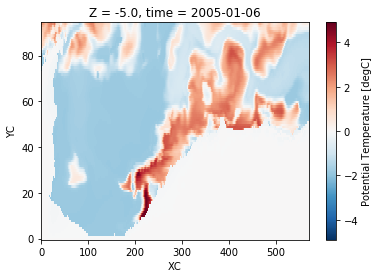

In [31]:
dsr.THETA[0,0].isel(**lat_range, **lon_range).plot()#.drop(['XC', 'YC']).plot()

In [9]:
temp_wg = dsr.THETA.isel(**lat_range, **lon_range)

In [10]:
temp_wg_mean = temp_wg.mean(dim='time')
temp_wg_mean

<xarray.DataArray 'THETA' (Z: 42, YC: 95, XC: 570)>
dask.array<mean_agg-aggregate, shape=(42, 95, 570), dtype=float32, chunksize=(42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
Dimensions without coordinates: YC, XC

In [11]:
#this gives us the depth of the bottom cell
depth_max = dsr.Z.where(temp_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [12]:
depth_max

<xarray.DataArray 'Z' (YC: 95, XC: 570)>
dask.array<nanmax-aggregate, shape=(95, 570), dtype=float32, chunksize=(95, 570), chunktype=numpy.ndarray>
Dimensions without coordinates: YC, XC

In [14]:
bottom_temp = temp_wg_mean.sel(Z=depth_max.fillna(0.)).load()

<xarray.DataArray 'THETA' (YC: 95, XC: 570)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.59500206,  0.59372324,  0.5860209 , ..., -0.61448747,
        -0.61401767, -0.6136384 ],
       [ 0.7132437 ,  0.7120261 ,  0.7027545 , ..., -0.5988263 ,
        -0.59873897, -0.5980881 ],
       [ 0.8445248 ,  0.8352686 ,  0.8186579 , ..., -0.57839876,
        -0.5790265 , -0.5787111 ]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
Dimensions without coordinates: YC, XC

In [15]:
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0).load()

In [16]:
lon = coords_before_drop.XC.isel(**lon_range)
lat = coords_before_drop.YC.isel(**lat_range)

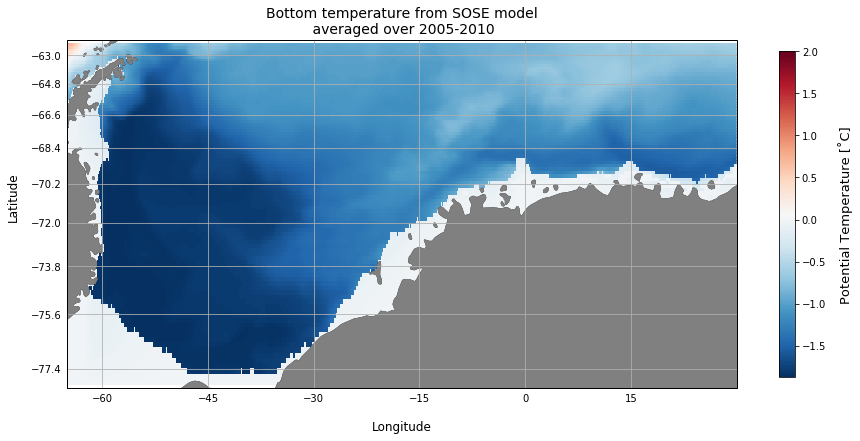

In [17]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_temp, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from SOSE model\n averaged over 2005-2010', fontsize=14);

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [18]:
std_temp = temp_wg.std('time').load()

In [19]:
std_temp

<xarray.DataArray 'THETA' (Z: 42, YC: 95, XC: 570)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.9401149 , 1.9315456 , 1.925773  , ..., 1.6168126 ,
         1.6183969 , 1.6180696 ],
        [1.9405234 , 1.9307938 , 1.9231234 , ..., 1.6200324 ,
         1.6224138 , 1.6237788 ],
        [1.9323751 , 1.9223851 , 1.9137712 , ..., 1.6269828 ,
         1.6288462 , 1.6300234 ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.9149448 , 1.9056659 , 1.8992227 , ..., 1.5215387 ,
         1.5177867 , 1.5137357 ],
        [1.9147937 , 1.9046569 , 1.8963498 , ..., 1.5428617 ,
         1.5382938 , 1.5330676 ],
        [1.9077557 , 1.8978242 , 1.8891155 , ..., 1.5585115 ,
         1.5541234 , 1.5486827 ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.7712417 , 1.7572767 , 1.7449166 , ..., 1.2601472 ,
         1.2582256 , 1.2556542 ],
        [1.7886424 , 1.7758652 , 1.7639375 , ..., 1.2903346 ,
         1.287048  , 1.2828501 ],
        [1.7941483 , 1.783451  , 1.7722386 , ..., 1.314885  ,
         1.3100916 , 1.304357  ]],

       ...,

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.0028429 ,
         0.00289267, 0.00294395],
        [0.        , 0.        , 0.        , ..., 0.00252161,
         0.00258635, 0.00267183],
        [0.        , 0.        , 0.        , ..., 0.00229265,
         0.00236523, 0.00247475]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
Dimensions without coordinates: YC, XC

In [20]:
#this gives us the depth of the bottom cell
depth_max_std_temp = dsr.Z.where(std_temp.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [21]:
depth_max_std_temp

<xarray.DataArray 'Z' (YC: 95, XC: 570)>
array([[-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       ...,
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.]], dtype=float32)
Dimensions without coordinates: YC, XC

In [22]:
bottom_std_temp = std_temp.sel(Z=depth_max_std_temp.fillna(0.)).load()

In [23]:
bottom_std_temp

<xarray.DataArray 'THETA' (YC: 95, XC: 570)>
array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [1.9401149, 1.9315456, 1.925773 , ..., 1.6168126, 1.6183969,
        1.6180696],
       [1.9405234, 1.9307938, 1.9231234, ..., 1.6200324, 1.6224138,
        1.6237788],
       [1.9323751, 1.9223851, 1.9137712, ..., 1.6269828, 1.6288462,
        1.6300234]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
Dimensions without coordinates: YC, XC

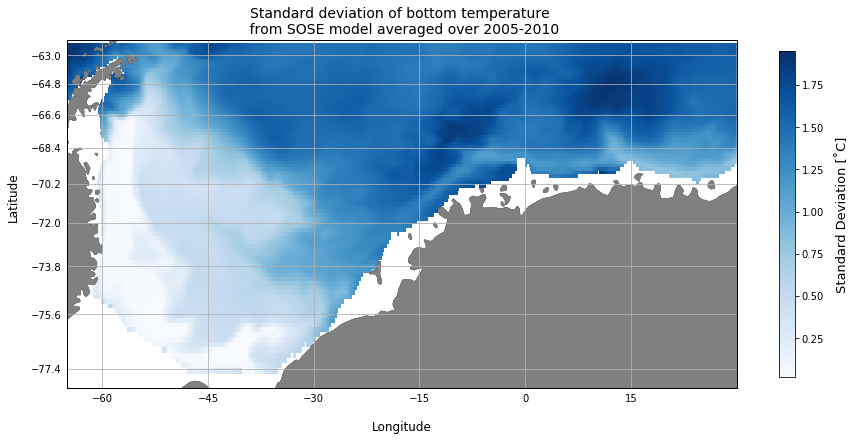

In [24]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
im = ax.pcolormesh(lon, lat, bottom_std_temp.where(surface_mask), transform=ccrs.PlateCarree(), cmap='Blues')#, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviation of bottom temperature \n from SOSE model averaged over 2005-2010', fontsize=14);

<span style='color:Green'> **The darker the blue, the more the datapoint is away from mean temperature**

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

## <span style='color:Red'> Bottom Temperature Z-score (start)

In [ ]:
plt.hist(bottom_temp); #different temp bins have normal/skewed distribution

In [26]:
from scipy import stats

In [27]:
#this gives us the depth of the bottom cell
depth_max_full_time = dsr.Z.where(temp_wg.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [28]:
depth_max_full_time

,Array,Chunk
Bytes,94.87 MB,216.60 kB
Shape,"(438, 95, 570)","(1, 95, 570)"
Count,5696 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [ ]:
bottom_temp_full_time = temp_wg.sel(Z=depth_max_full_time.fillna(0.)).load()

In [30]:
bottom_temp_full_time

,Array,Chunk
Bytes,94.87 MB,216.60 kB
Shape,"(438, 95, 570)","(1, 95, 570)"
Count,4819 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [ ]:
zscore_temp = stats.zscore(bottom_temp_full_time, axis=0)

## By hand

In [38]:
#manually calculated z-score
zscore_hand = (temp_wg - temp_wg_mean) / std_temp
zscore_hand

,Array,Chunk
Bytes,3.98 GB,9.10 MB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,4531 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [39]:
zscore_hand_mean = zscore_hand.mean(dim='time')

In [40]:
#this gives us the depth of the bottom cell
depth_max_zscore = dsr.Z.where(zscore_hand_mean.notnull()).max(dim='Z')

In [43]:
bottom_temp_zscore = zscore_hand_mean.sel(Z=depth_max.fillna(0.))

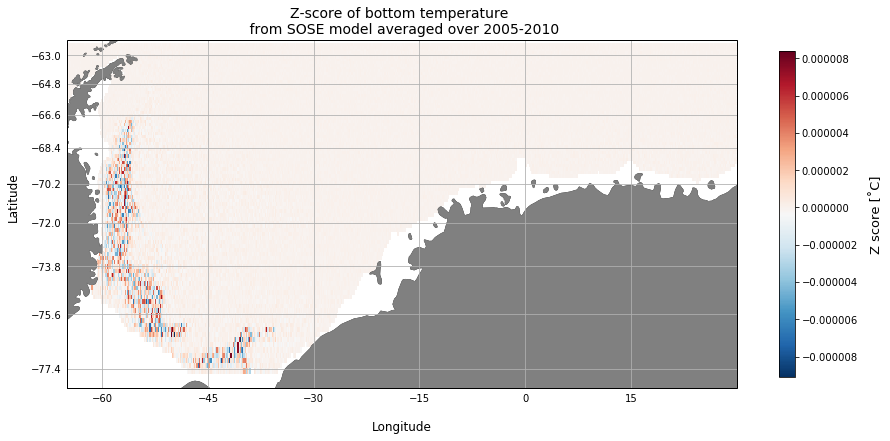

In [48]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
im = ax.pcolormesh(lon, lat, bottom_temp_zscore.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r')#, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Z score [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Z-score of bottom temperature \n from SOSE model averaged over 2005-2010', fontsize=14);

<span style='color:Green'> The highest Z-score value is 8e-6 which is 0.5 on the z-score table. So p>0.05 which means we can retain the null hypothesis (i.e. we can retain our assumption that the temperature distribution in the region is normal and carry on with our statistical anyalysis (standard deviation).

In [51]:
bottom_temp.size

54150

In [60]:
stats.shapiro(bottom_temp)

(0.871620237827301, 0.0)

In [61]:
print(stats.shapiro(bottom_temp), 
      ": p < 0.05 so bottom wg mean temp dataset is NOT normally distributed? But Shapiro p value less reliable for N>5000")

(0.871620237827301, 0.0) : p < 0.05 so bottom wg mean temp dataset is NOT normally distributed? But Shapiro p value less reliable for N>5000


## <span style='color:Red'> Bottom Temperature Z-score (end)

## BOTTOM SALT

In [33]:
slt_wg = dsr.SALT.isel(**lat_range, **lon_range)

In [34]:
slt_wg_mean = slt_wg.mean(dim='time')
slt_wg_mean

<xarray.DataArray 'SALT' (Z: 42, YC: 95, XC: 570)>
dask.array<mean_agg-aggregate, shape=(42, 95, 570), dtype=float32, chunksize=(42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
Dimensions without coordinates: YC, XC

In [35]:
#this gives us the depth of the bottom cell
depth_max_slt = dsr.Z.where(slt_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [36]:
bottom_slt = slt_wg_mean.sel(Z=depth_max_slt.fillna(0.)).load()

In [37]:
bottom_slt

<xarray.DataArray 'SALT' (YC: 95, XC: 570)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [33.708538, 33.709415, 33.709522, ..., 33.853043, 33.854958,
        33.856647],
       [33.72277 , 33.723537, 33.72321 , ..., 33.855934, 33.8571  ,
        33.858185],
       [33.741817, 33.74131 , 33.739555, ..., 33.85897 , 33.859295,
        33.85984 ]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
Dimensions without coordinates: YC, XC

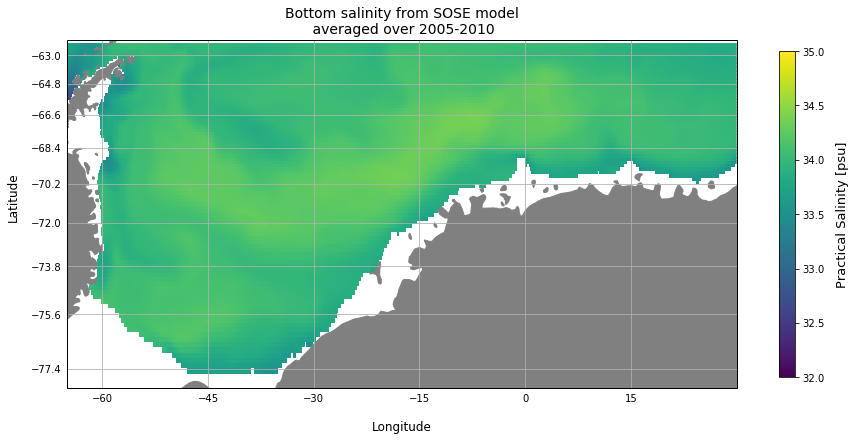

In [38]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_slt.where(surface_mask), transform=ccrs.PlateCarree(), vmin=32, vmax=35, cmap='viridis')

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Practical Salinity [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from SOSE model\n averaged over 2005-2010', fontsize=14, );

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

In [39]:
std_slt = slt_wg.std('time').load()

In [40]:
std_slt

<xarray.DataArray 'SALT' (Z: 42, YC: 95, XC: 570)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.16349815, 0.16455886, 0.16600156, ..., 0.26004484,
         0.2624796 , 0.26455685],
        [0.15929526, 0.15990709, 0.16109149, ..., 0.24494264,
         0.24762833, 0.2505836 ],
        [0.15186515, 0.15275356, 0.15425907, ..., 0.23001364,
         0.23254564, 0.2355742 ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.16210216, 0.1632158 , 0.16470322, ..., 0.21205127,
         0.21424107, 0.2160756 ],
        [0.15795499, 0.15868701, 0.1599494 , ..., 0.20117198,
         0.20398875, 0.20677724],
        [0.15079904, 0.15179214, 0.15335299, ..., 0.1897045 ,
         0.19226754, 0.19528441]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.15243666, 0.1532057 , 0.15439887, ..., 0.16096786,
         0.16282417, 0.16421185],
        [0.14926426, 0.15007961, 0.15130714, ..., 0.15094784,
         0.15349148, 0.15590902],
        [0.14410055, 0.14497231, 0.14630999, ..., 0.14220469,
         0.14475018, 0.14756124]],

       ...,

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00056096,
         0.00052945, 0.00049703],
        [0.        , 0.        , 0.        , ..., 0.00060582,
         0.00057894, 0.00055155],
        [0.        , 0.        , 0.        , ..., 0.00067496,
         0.0006566 , 0.00063605]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
Dimensions without coordinates: YC, XC

In [41]:
#this gives us the depth of the bottom cell
depth_max_std_slt = dsr.Z.where(std_slt.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [42]:
bottom_std_slt = std_slt.sel(Z=depth_max_std_slt.fillna(0.)).load()

In [43]:
bottom_std_slt

<xarray.DataArray 'SALT' (YC: 95, XC: 570)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.16349815, 0.16455886, 0.16600156, ..., 0.26004484, 0.2624796 ,
        0.26455685],
       [0.15929526, 0.15990709, 0.16109149, ..., 0.24494264, 0.24762833,
        0.2505836 ],
       [0.15186515, 0.15275356, 0.15425907, ..., 0.23001364, 0.23254564,
        0.2355742 ]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
Dimensions without coordinates: YC, XC

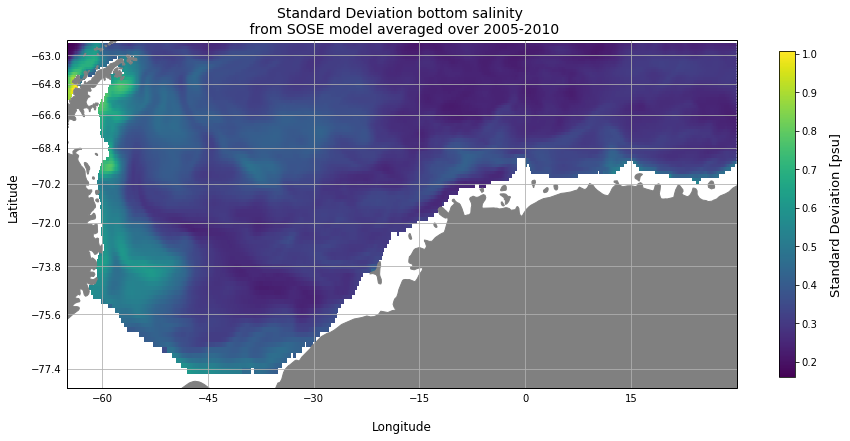

In [44]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_std_slt.where(surface_mask), transform=ccrs.PlateCarree(), cmap='viridis')

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Deviation [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation bottom salinity \n from SOSE model averaged over 2005-2010', fontsize=14, );

## <span style='color:Red'> Bottom Salinity Standard Deviation (end)

## <span style='color:Red'> Bottom Salinity Z-score (start)

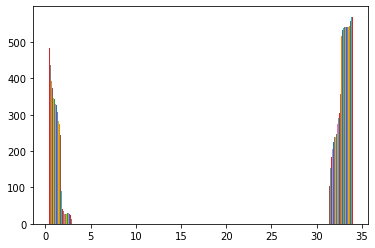

In [45]:
plt.hist(bottom_slt); #different temp bins have normal/skewed distribution

In [48]:
#this gives us the depth of the bottom cell
depth_max_full_time_slt = dsr.Z.where(slt_wg.notnull()).max(dim='Z') 

In [49]:
depth_max_full_time_slt

,Array,Chunk
Bytes,94.87 MB,216.60 kB
Shape,"(438, 95, 570)","(1, 95, 570)"
Count,5696 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [ ]:
bottom_slt_full_time = slt_wg.sel(Z=depth_max_full_time_slt.fillna(0.)).load()

In [52]:
bottom_slt_full_time

<xarray.DataArray 'SALT' (time: 438, YC: 95, XC: 570)>
array([[[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [33.51701 , 33.497524, 33.482155, ..., 33.348927, 33.352257,
         33.354195],
        [33.53822 , 33.523457, 33.51137 , ..., 33.3506  , 33.35079 ,
         33.350414],
        [33.575176, 33.564312, 33.55455 , ..., 33.36662 , 33.363422,
         33.36066 ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [33.54067 , 33.515903, 33.495167, ..., 33.3428  , 33.345577,
         33.34727 ],
        [33.53821 , 33.521057, 33.50881 , ..., 33.35865 , 33.35894 ,
         33.358727],
        [33.570908, 33.558395, 33.550213, ..., 33.379158, 33.376152,
         33.373623]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [33.588787, 33.554962, 33.51958 , ..., 33.36164 , 33.364315,
         33.36581 ],
        [33.561535, 33.53258 , 33.50687 , ..., 33.391518, 33.390392,
         33.387623],
        [33.568092, 33.5456  , 33.529175, ..., 33.413746, 33.41108 ,
         33.409035]],

       ...,

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [33.663654, 33.663334, 33.665802, ..., 33.980446, 33.975246,
         33.968754],
        [33.67038 , 33.67279 , 33.6756  , ..., 33.950294, 33.945198,
         33.94066 ],
        [33.677486, 33.68093 , 33.684315, ..., 33.931454, 33.927113,
         33.924576]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [33.655758, 33.653706, 33.653347, ..., 33.882233, 33.87707 ,
         33.87206 ],
        [33.655857, 33.656654, 33.6565  , ..., 33.85377 , 33.84955 ,
         33.846367],
        [33.663155, 33.6649  , 33.66546 , ..., 33.8402  , 33.836414,
         33.833954]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [33.62193 , 33.62279 , 33.62438 , ..., 33.713257, 33.71072 ,
         33.708775],
        [33.62265 , 33.626827, 33.627415, ..., 33.685448, 33.68249 ,
         33.680206],
        [33.62755 , 33.631622, 33.63171 , ..., 33.67029 , 33.666107,
         33.662743]]], dtype=float32)
Coordinates:
    Z        (time, YC, XC) float64 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Dimensions without coordinates: YC, XC
Attributes:
    long_name:      Salinity
    standard_name:  SALT
    units:          psu

In [53]:
bottom_slt_full_time.std(dim='time')

<xarray.DataArray 'SALT' (YC: 95, XC: 570)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.16349746, 0.1645586 , 0.16600108, ..., 0.26004466, 0.2624794 ,
        0.26455656],
       [0.15929529, 0.15990628, 0.16109172, ..., 0.24494223, 0.24762887,
        0.25058368],
       [0.15186542, 0.15275355, 0.15425888, ..., 0.23001435, 0.2325456 ,
        0.23557389]], dtype=float32)
Dimensions without coordinates: YC, XC

In [56]:
zscore_slt = stats.zscore(bottom_slt_full_time, axis=0)

## By hand

In [61]:
#manually calculated z-score
zscore_hand_slt = (slt_wg - slt_wg_mean) / std_slt
zscore_hand_slt

,Array,Chunk
Bytes,3.98 GB,9.10 MB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,4531 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [62]:
zscore_hand_slt_mean = zscore_hand_slt.mean(dim='time')

In [63]:
#this gives us the depth of the bottom cell
depth_max_zscore_slt = dsr.Z.where(zscore_hand_slt_mean.notnull()).max(dim='Z')

In [64]:
bottom_slt_zscore = zscore_hand_slt_mean.sel(Z=depth_max.fillna(0.))

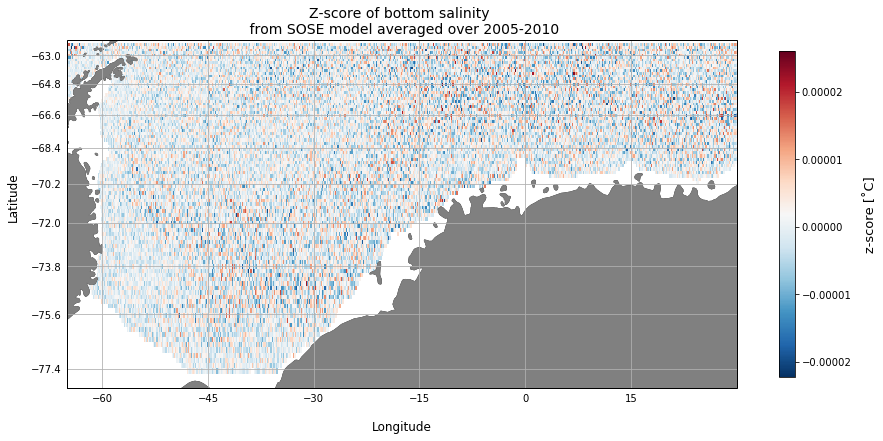

In [65]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
im = ax.pcolormesh(lon, lat, bottom_slt_zscore.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r')#, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("z-score [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Z-score of bottom salinity \n from SOSE model averaged over 2005-2010', fontsize=14);

<span style='color:Green'> The highest Z-score value is 2e-5 which is 0.5 on the z-score table. So p>0.05 which means we can retain the null hypothesis (i.e. we can retain our assumption that the temperature distribution in the region is normal and carry on with our statistical anyalysis (standard deviation).

In [66]:
bottom_slt.size

54150

In [67]:
stats.shapiro(bottom_slt)

/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.6037768125534058, 0.0)

In [69]:
print(stats.shapiro(bottom_slt), 
      ": p < 0.05 so bottom wg mean temp dataset is NOT normally distributed? But Shapiro p value less reliable for N>5000")

(0.6037768125534058, 0.0) : p < 0.05 so bottom wg mean temp dataset is NOT normally distributed? But Shapiro p value less reliable for N>5000


## <span style='color:Red'> Bottom Salinity Z-score (end)